In [1]:
import pandas as pd
import os

# 所有文件名及其路径
folder = 'csv_symbol'
filenames = [
    'E-MTAB-316_symbol.csv',
    'E-MTAB-317_symbol.csv',
    'GSE2113_symbol.csv',
    'GSE5900_symbol.csv',
    'GSE6477_symbol.csv',
    'GSE13591_symbol.csv',
    'GSE235356_symbol.csv'
]

# 1. 获取所有数据集的基因交集（列名，从第2列开始）
gene_sets = []
for file in filenames:
    df = pd.read_csv(os.path.join(folder, file))
    genes = set(df.columns[1:])  # 排除 SampleID
    gene_sets.append(genes)

# 计算交集
common_genes = set.intersection(*gene_sets)
common_genes = sorted(list(common_genes))  # 排序方便统一列顺序

print(f"交集基因数量：{len(common_genes)}")

# 2. 标准化并合并所有数据集
merged_list = []

for file in filenames:
    dataset_name = file.replace('_symbol.csv', '')
    df = pd.read_csv(os.path.join(folder, file))

    # 仅保留 SampleID、交集基因
    df_common = df[['SampleID'] + common_genes].copy()
    df_common.insert(1, 'Dataset', dataset_name)  # 插入 Dataset 列在第二列
    merged_list.append(df_common)

# 合并所有数据集
merged_df = pd.concat(merged_list, axis=0)

# 保存为 CSV
merged_df.to_csv('merged_intersected_symbol_with_dataset.csv', index=False)

print("✅ 合并完成，文件保存为 merged_intersected_symbol_with_dataset.csv")

交集基因数量：12920
✅ 合并完成，文件保存为 merged_intersected_symbol_with_dataset.csv


In [17]:
import pandas as pd
import numpy as np

# 读取数据
df = pd.read_csv("merged_intersected_symbol_with_dataset.csv")

# 提取所有数据集
datasets = df["Dataset"].unique()

# 判断每个数据集是否已 log2 转换
log2_status = {}

for ds in datasets:
    subset = df[df["Dataset"] == ds]
    expression_values = subset.drop(columns=["SampleID", "Dataset"])
    q75 = expression_values.apply(lambda x: np.percentile(x, 75))
    log2_status[ds] = all(q75 < 16)  # True 表示已经 log2 转换

# 输出状态
for ds, is_log2 in log2_status.items():
    print(f"{ds}: {'已log2转换' if is_log2 else '未转换'}")

E-MTAB-316: 未转换
E-MTAB-317: 未转换
GSE2113: 未转换
GSE5900: 未转换
GSE6477: 未转换
GSE13591: 已log2转换
GSE235356: 未转换


In [18]:
# 复制一份原始数据
df_log2 = df.copy()

# 对每个未 log2 转换的数据集进行转换
for ds, is_log2 in log2_status.items():
    if not is_log2:
        idx = df_log2["Dataset"] == ds
        expr_cols = df_log2.columns.difference(["SampleID", "Dataset"])
        df_log2.loc[idx, expr_cols] = df_log2.loc[idx, expr_cols].applymap(lambda x: np.log2(x + 1))

# 保存转换后的文件
df_log2.to_csv("merged_intersected_symbol_with_dataset_log2transformed.csv", index=False)

/var/folders/j3/_3qg9gs11jjc7473nnygd52r0000gn/T/ipykernel_40983/3475018168.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_log2.loc[idx, expr_cols] = df_log2.loc[idx, expr_cols].applymap(lambda x: np.log2(x + 1))
/var/folders/j3/_3qg9gs11jjc7473nnygd52r0000gn/T/ipykernel_40983/3475018168.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_log2.loc[idx, expr_cols] = df_log2.loc[idx, expr_cols].applymap(lambda x: np.log2(x + 1))
/var/folders/j3/_3qg9gs11jjc7473nnygd52r0000gn/T/ipykernel_40983/3475018168.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_log2.loc[idx, expr_cols] = df_log2.loc[idx, expr_cols].applymap(lambda x: np.log2(x + 1))
/var/folders/j3/_3qg9gs11jjc7473nnygd52r0000gn/T/ipykernel_40983/3475018168.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_log2.loc[idx, expr_cols] = df_log2.loc[idx, expr_cols]

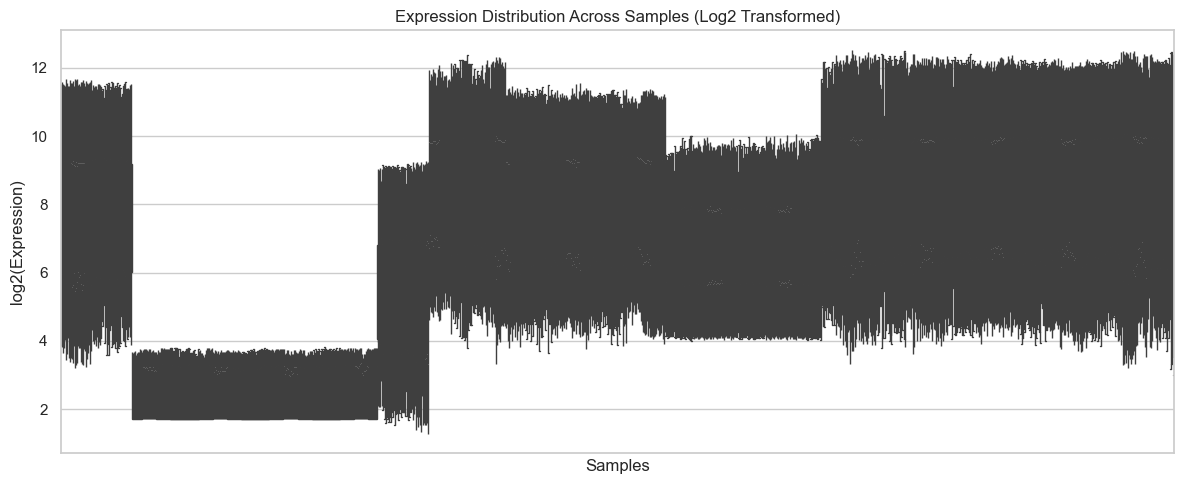

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
df = pd.read_csv("merged_intersected_symbol_with_dataset_log2transformed.csv")

# 去除非表达数据列
expr = df.drop(columns=["SampleID", "Dataset"])

# 转置为 gene × sample 格式
expr_T = expr.transpose()

# 查看各样本分位点
quantiles = expr_T.quantile([0.25, 0.5, 0.75])

# 绘图：分位点热图
plt.figure(figsize=(12, 5))
sns.boxplot(data=expr_T, whis=[5, 95], showfliers=False)
plt.xticks([], [])  # 不显示所有样本名，避免太密
plt.title("Expression Distribution Across Samples (Log2 Transformed)")
plt.ylabel("log2(Expression)")
plt.xlabel("Samples")
plt.tight_layout()
plt.show()

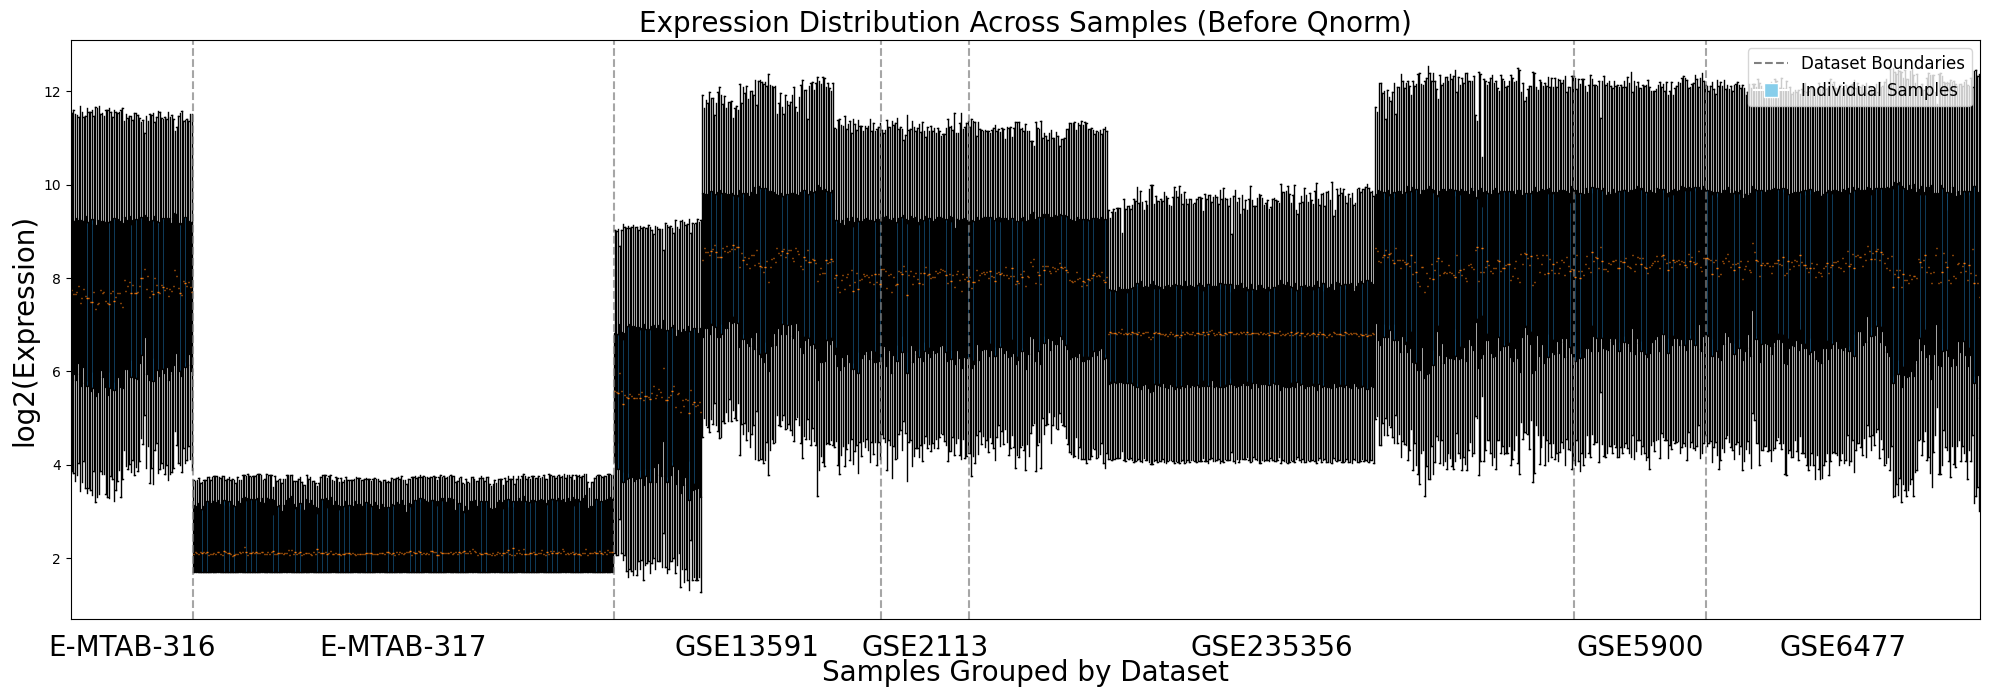

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# 读取数据
df = pd.read_csv("merged_intersected_symbol_with_dataset_log2transformed.csv")

# 提取表达数据、样本ID与数据集标签
expr = df.drop(columns=["SampleID", "Dataset"])
sample_ids = df["SampleID"].values
datasets = df["Dataset"].values

# 按数据集分组样本
dataset_groups = {}
current_idx = 0
for dataset in np.unique(datasets):
    count = sum(datasets == dataset)
    dataset_groups[dataset] = (current_idx, current_idx + count - 1)
    current_idx += count

# 创建图形
plt.figure(figsize=(20, 8))

# 创建箱线图（样本级）
box = plt.boxplot(
    expr.values.T, 
    patch_artist=True, 
    showfliers=False, 
    whis=[5, 95],
    widths=0.7,
    positions=np.arange(len(expr)))

plt.title("Expression Distribution Across Samples (Before Qnorm)", fontsize=20)
plt.ylabel("log2(Expression)", fontsize=20)
plt.xlabel("Samples Grouped by Dataset", fontsize=20, labelpad=29)
plt.xticks([])  # 隐藏样本级刻度

# 添加数据集分隔线和标签
ax = plt.gca()
y_min, y_max = ax.get_ylim()
offset = (y_max - y_min) * 0.05  # 标签偏移量

for dataset, (start_idx, end_idx) in dataset_groups.items():
    if start_idx > 0:
        plt.axvline(x=start_idx - 0.5, color='gray', linestyle='--', alpha=0.7)
    
    mid_point = (start_idx + end_idx) / 2
    plt.text(
        mid_point, 
        y_min - offset, 
        dataset, 
        ha='center', 
        va='center', 
        fontsize=20,
        rotation=0
    )

# 添加图例说明
legend_elements = [
    Line2D([0], [0], color='gray', ls='--', label='Dataset Boundaries'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='skyblue', 
           markersize=10, label='Individual Samples')
]
plt.legend(handles=legend_elements, loc='upper right', prop={'size': 12})

plt.tight_layout()
plt.subplots_adjust(bottom=0.22)  # 为底部横向标签留出空间
plt.show()

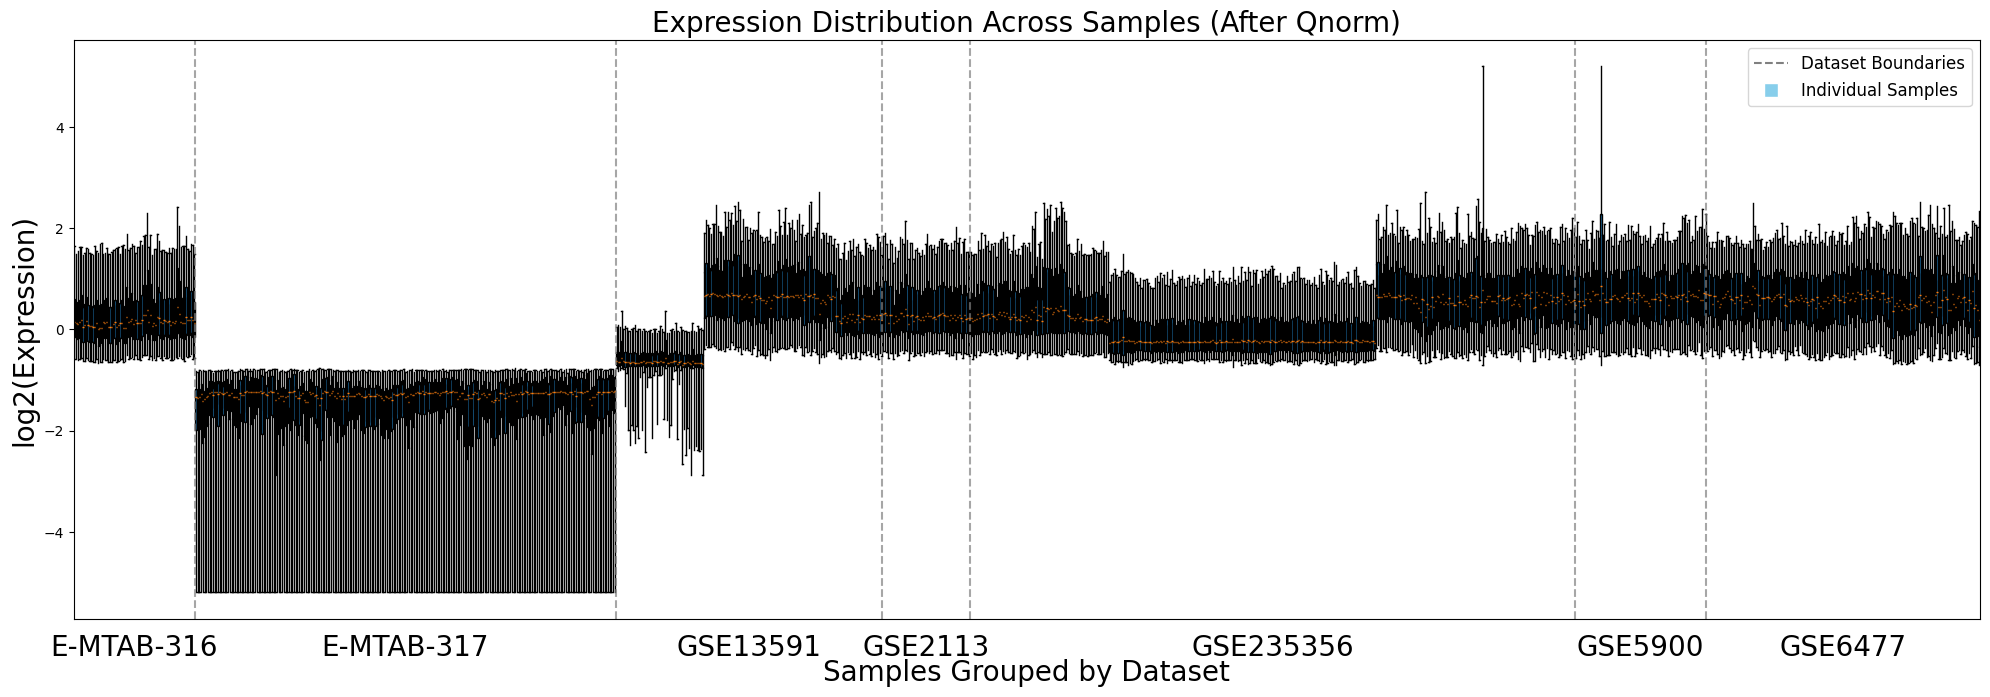

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# 读取数据
df = pd.read_csv("merged_qnorm_log2.csv")

# 提取表达数据、样本ID与数据集标签
expr = df.drop(columns=["SampleID", "Dataset"])
sample_ids = df["SampleID"].values
datasets = df["Dataset"].values

# 按数据集分组样本
dataset_groups = {}
current_idx = 0
for dataset in np.unique(datasets):
    count = sum(datasets == dataset)
    dataset_groups[dataset] = (current_idx, current_idx + count - 1)
    current_idx += count

# 创建图形
plt.figure(figsize=(20, 8))

# 创建箱线图（样本级）
box = plt.boxplot(
    expr.values.T, 
    patch_artist=True, 
    showfliers=False, 
    whis=[5, 95],
    widths=0.7,
    positions=np.arange(len(expr)))

plt.title("Expression Distribution Across Samples (After Qnorm)", fontsize=20)
plt.ylabel("log2(Expression)", fontsize=20)
plt.xlabel("Samples Grouped by Dataset", fontsize=20, labelpad=29)
plt.xticks([])  # 隐藏样本级刻度

# 添加数据集分隔线和标签
ax = plt.gca()
y_min, y_max = ax.get_ylim()
offset = (y_max - y_min) * 0.05  # 标签偏移量

for dataset, (start_idx, end_idx) in dataset_groups.items():
    if start_idx > 0:
        plt.axvline(x=start_idx - 0.5, color='gray', linestyle='--', alpha=0.7)
    
    mid_point = (start_idx + end_idx) / 2
    plt.text(
        mid_point, 
        y_min - offset, 
        dataset, 
        ha='center', 
        va='center', 
        fontsize=20,
        rotation=0
    )

# 添加图例说明
legend_elements = [
    Line2D([0], [0], color='gray', ls='--', label='Dataset Boundaries'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='skyblue', 
           markersize=10, label='Individual Samples')
]
plt.legend(handles=legend_elements, loc='upper right', prop={'size': 12})

plt.tight_layout()
plt.subplots_adjust(bottom=0.22)  # 为底部横向标签留出空间
plt.show()

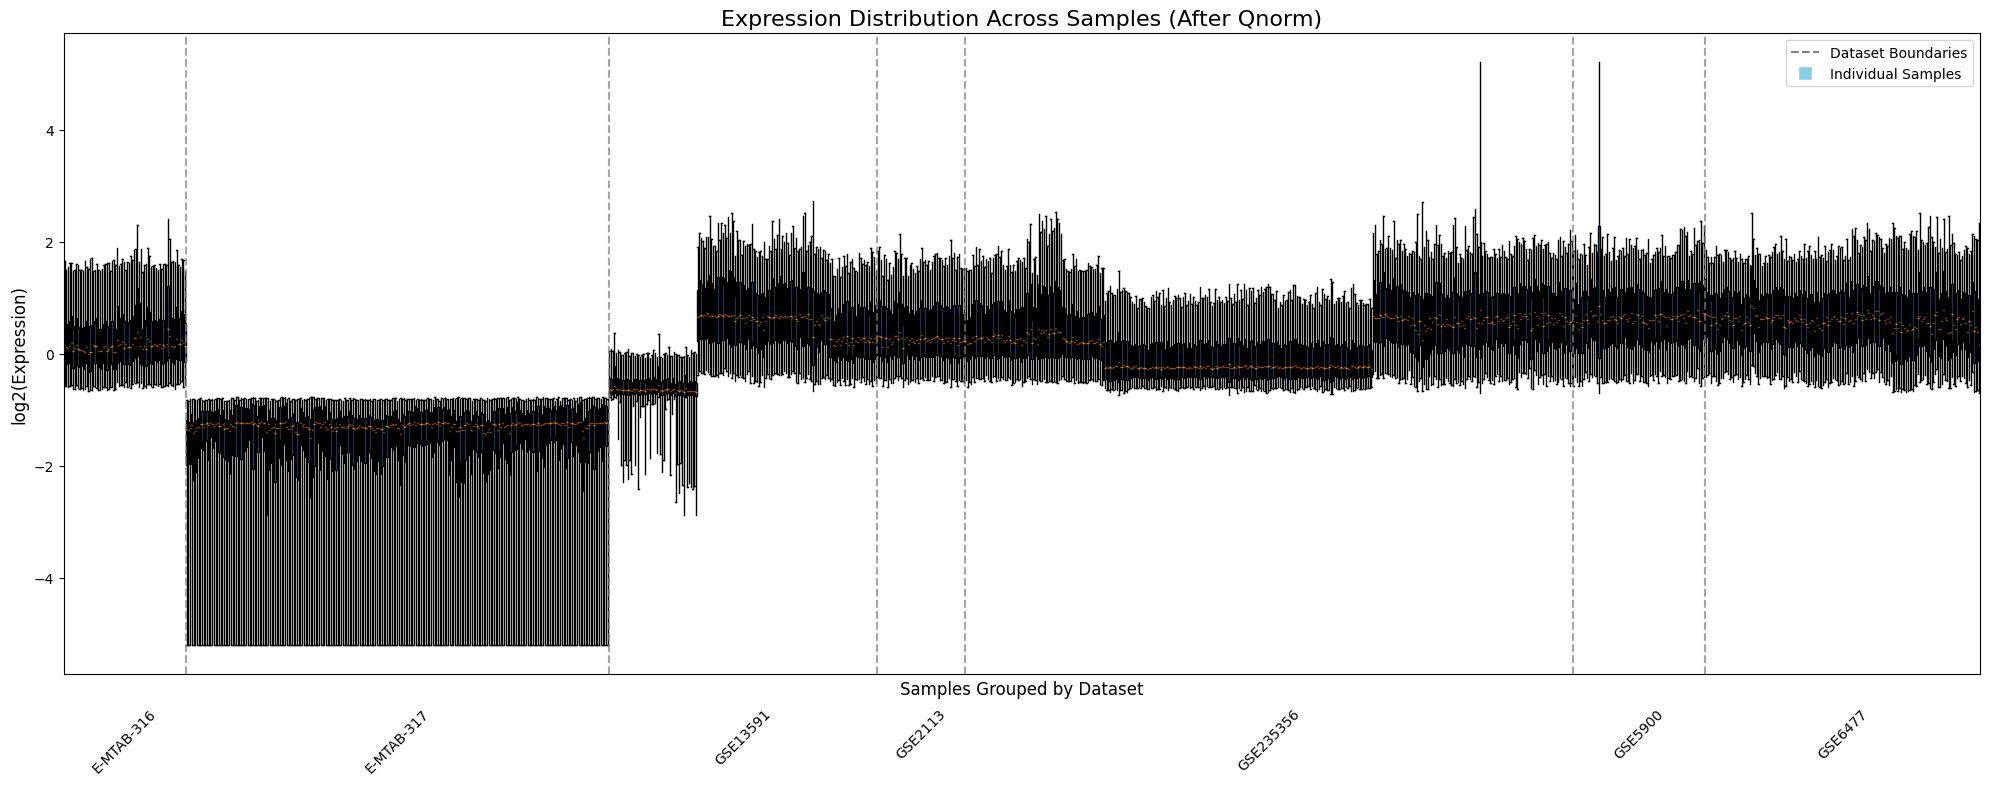

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# 读取数据
df = pd.read_csv("merged_qnorm_log2.csv")

# 提取表达数据、样本ID与数据集标签
expr = df.drop(columns=["SampleID", "Dataset"])
sample_ids = df["SampleID"].values
datasets = df["Dataset"].values

# 按数据集分组样本
dataset_groups = {}
current_idx = 0
for dataset in np.unique(datasets):
    count = sum(datasets == dataset)
    dataset_groups[dataset] = (current_idx, current_idx + count - 1)
    current_idx += count

# 创建图形
plt.figure(figsize=(20, 8))

# 创建箱线图（样本级）
box = plt.boxplot(
    expr.values.T, 
    patch_artist=True, 
    showfliers=False, 
    whis=[5, 95],
    widths=0.7,
    positions=np.arange(len(expr)))
plt.title("Expression Distribution Across Samples (After Qnorm)", fontsize=16)
plt.ylabel("log2(Expression)", fontsize=12)
plt.xlabel("Samples Grouped by Dataset", fontsize=12)
plt.xticks([])  # 隐藏样本级刻度

# 添加数据集分隔线和标签
ax = plt.gca()
y_min, y_max = ax.get_ylim()
offset = (y_max - y_min) * 0.05  # 标签偏移量

# 添加数据集分隔线
for dataset, (start_idx, end_idx) in dataset_groups.items():
    if start_idx > 0:  # 跳过第一个数据集的分隔线
        plt.axvline(x=start_idx - 0.5, color='gray', linestyle='--', alpha=0.7)
    
    # 在数据集中间位置添加标签
    mid_point = (start_idx + end_idx) / 2
    plt.text(
        mid_point, 
        y_min - offset, 
        dataset, 
        ha='center', 
        va='top', 
        fontsize=10,
        rotation=45
    )

# 添加图例说明
legend_elements = [
    Line2D([0], [0], color='gray', ls='--', label='Dataset Boundaries'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='skyblue', 
           markersize=10, label='Individual Samples')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # 为底部标签留出空间
plt.show()

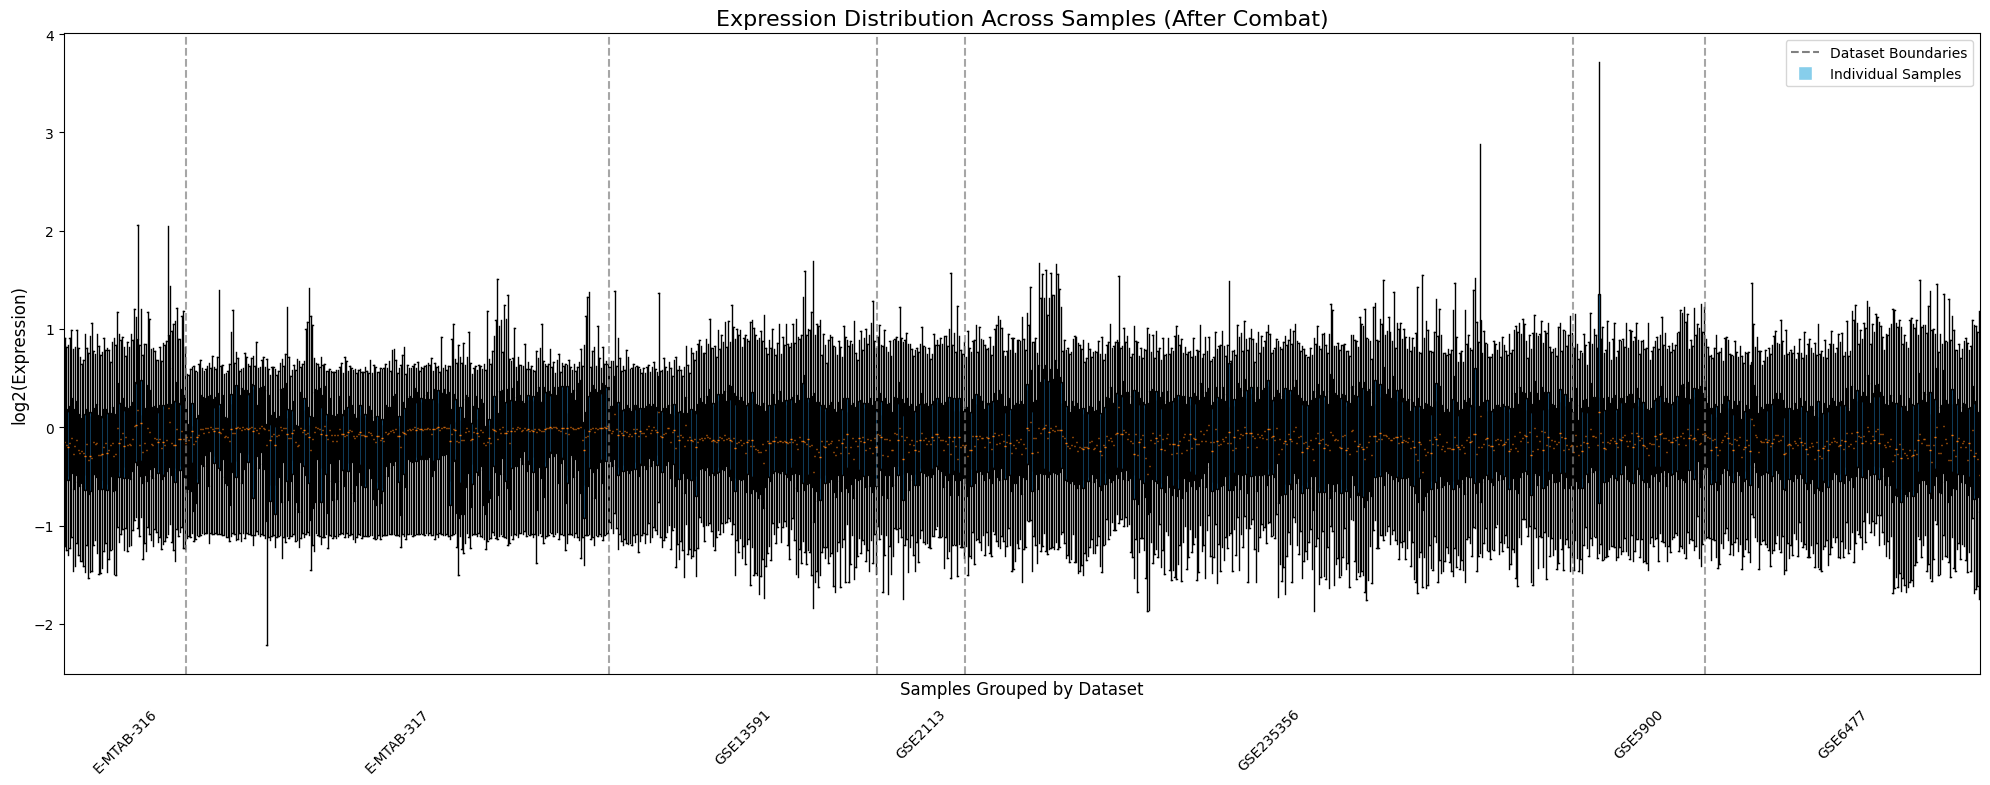

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# 读取数据
df = pd.read_csv("merged_qnorm_combat.csv")

# 提取表达数据、样本ID与数据集标签
expr = df.drop(columns=["SampleID", "Dataset"])
sample_ids = df["SampleID"].values
datasets = df["Dataset"].values

# 按数据集分组样本
dataset_groups = {}
current_idx = 0
for dataset in np.unique(datasets):
    count = sum(datasets == dataset)
    dataset_groups[dataset] = (current_idx, current_idx + count - 1)
    current_idx += count

# 创建图形
plt.figure(figsize=(20, 8))

# 创建箱线图（样本级）
box = plt.boxplot(
    expr.values.T, 
    patch_artist=True, 
    showfliers=False, 
    whis=[5, 95],
    widths=0.7,
    positions=np.arange(len(expr)))
plt.title("Expression Distribution Across Samples (After Combat)", fontsize=16)
plt.ylabel("log2(Expression)", fontsize=12)
plt.xlabel("Samples Grouped by Dataset", fontsize=12)
plt.xticks([])  # 隐藏样本级刻度

# 添加数据集分隔线和标签
ax = plt.gca()
y_min, y_max = ax.get_ylim()
offset = (y_max - y_min) * 0.05  # 标签偏移量

# 添加数据集分隔线
for dataset, (start_idx, end_idx) in dataset_groups.items():
    if start_idx > 0:  # 跳过第一个数据集的分隔线
        plt.axvline(x=start_idx - 0.5, color='gray', linestyle='--', alpha=0.7)
    
    # 在数据集中间位置添加标签
    mid_point = (start_idx + end_idx) / 2
    plt.text(
        mid_point, 
        y_min - offset, 
        dataset, 
        ha='center', 
        va='top', 
        fontsize=10,
        rotation=45
    )

# 添加图例说明
legend_elements = [
    Line2D([0], [0], color='gray', ls='--', label='Dataset Boundaries'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='skyblue', 
           markersize=10, label='Individual Samples')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # 为底部标签留出空间
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
df = pd.read_csv("merged_intersected_symbol_with_dataset_log2transformed.csv")

# 按数据集分组并重组数据
melted_df = df.melt(id_vars=["SampleID", "Dataset"], 
                    var_name="Gene", 
                    value_name="Expression")

# 按数据集生成颜色
unique_datasets = melted_df["Dataset"].unique()
palette = sns.color_palette("tab10", len(unique_datasets))
dataset_to_color = dict(zip(unique_datasets, palette))

# 创建分组箱线图
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=melted_df,
    x="Dataset",
    y="Expression",
    palette=palette,
    showfliers=False,
    whis=[5, 95],
    width=0.7
)

# 图形设置
plt.title("Expression Distribution by Dataset (Log2 Transformed, Before Qnorm)", fontsize=14)
plt.ylabel("log2(Expression)")
plt.xlabel("Dataset")
plt.xticks(rotation=45, ha='right')  # 旋转数据集标签防止重叠

plt.tight_layout()
plt.show()

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import QuantileTransformer

# 读取原始 log2 文件
df = pd.read_csv("merged_intersected_symbol_with_dataset_log2transformed.csv")

# 分离元数据列
metadata_cols = ["SampleID", "Dataset"]
meta = df[metadata_cols]
expr = df.drop(columns=metadata_cols)

# 使用 QuantileTransformer 进行标准化
qt = QuantileTransformer(output_distribution='normal', random_state=42, copy=True)
expr_qnorm = qt.fit_transform(expr)

# 转回 DataFrame 并恢复列名
expr_qnorm_df = pd.DataFrame(expr_qnorm, columns=expr.columns)

# 合并元数据和表达数据
df_qnorm = pd.concat([meta, expr_qnorm_df], axis=1)

# 保存为新文件
df_qnorm.to_csv("merged_qnorm_log2.csv", index=False)

print("✅ Quantile normalization 完成，结果已保存为 merged_qnorm_log2.csv")

✅ Quantile normalization 完成，结果已保存为 merged_qnorm_log2.csv


In [26]:
import pandas as pd

# 读取校正后的文件
df = pd.read_csv('merged_qnorm_combat.csv')

# 输出形状
print(f"总行数（样本数）: {df.shape[0]}")
print(f"总列数（包括 SampleID 和 Dataset）: {df.shape[1]}")
print(f"基因数（排除前两列）: {df.shape[1] - 2}")

总行数（样本数）: 1129
总列数（包括 SampleID 和 Dataset）: 12922
基因数（排除前两列）: 12920


In [25]:
import pandas as pd
from pycombat import Combat

# 读取 quantile normalization 后的表达矩阵
df = pd.read_csv('merged_qnorm_log2.csv')

# 分离 meta 信息和表达矩阵
metadata = df[['SampleID', 'Dataset']]
expr = df.drop(columns=['SampleID', 'Dataset'])

# 转换表达矩阵为 numpy 数组
expr_array = expr.to_numpy()

# 初始化并执行 Combat 批次效应校正
combat = Combat()
expr_corrected = combat.fit_transform(expr_array, metadata['Dataset'].values)

# 转回 DataFrame 并加上列名
expr_corrected_df = pd.DataFrame(expr_corrected, columns=expr.columns)
expr_corrected_df.insert(0, 'Dataset', metadata['Dataset'].values)
expr_corrected_df.insert(0, 'SampleID', metadata['SampleID'].values)

# 保存
expr_corrected_df.to_csv('merged_qnorm_combat.csv', index=False)

print("✅ 使用 pycombat 校正完成，结果已保存为 merged_qnorm_combat.csv")

/Users/kylin/.pyenv/versions/3.10.13/lib/python3.10/site-packages/pycombat/pycombat.py:79: RuntimeWarning: divide by zero encountered in divide
  (abs(del_sq_post - del_sq_prior) / del_sq_prior).max())


✅ 使用 pycombat 校正完成，结果已保存为 merged_qnorm_combat.csv


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

def run_pca_and_plot(file, prefix):
    # 读取数据
    df = pd.read_csv(file)
    meta = df[['SampleID', 'Dataset']]
    expr = df.drop(columns=['SampleID', 'Dataset'])

    # PCA
    pca = PCA(n_components=10)
    pcs = pca.fit_transform(expr)
    pca_df = pd.DataFrame(pcs[:, :3], columns=['PC1', 'PC2', 'PC3'])
    pca_df['Dataset'] = meta['Dataset'].values

    # 绘图函数
    def plot_pair(x, y, suffix):
        plt.figure(figsize=(6, 5))
        sns.scatterplot(data=pca_df, x=x, y=y, hue='Dataset', s=50, alpha=0.8)
        plt.title(f'{prefix}: {x} vs {y}')
        plt.tight_layout()
        plt.savefig(f'{prefix}_{x}_vs_{y}.png')
        plt.close()

    # 三种组合图
    plot_pair('PC1', 'PC2', 'pc1vs2')
    plot_pair('PC1', 'PC3', 'pc1vs3')
    plot_pair('PC2', 'PC3', 'pc2vs3')

    # 输出解释度
    explained = pca.explained_variance_ratio_[:3] * 100
    print(f"🔎 {prefix} PCA Explained Variance: PC1={explained[0]:.2f}%, PC2={explained[1]:.2f}%, PC3={explained[2]:.2f}%")

# 🔹 校正前
run_pca_and_plot("merged_qnorm_log2.csv", prefix="Before_ComBat")

# 🔹 校正后
run_pca_and_plot("merged_qnorm_combat.csv", prefix="After_ComBat")

🔎 Before_ComBat PCA Explained Variance: PC1=72.34%, PC2=5.60%, PC3=1.67%
🔎 After_ComBat PCA Explained Variance: PC1=9.28%, PC2=2.64%, PC3=2.37%


In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

def run_pca_and_plot(file, prefix):
    # 创建保存目录
    os.makedirs("pacnew", exist_ok=True)

    # 读取数据
    df = pd.read_csv(file)
    meta = df[['SampleID', 'Dataset']]
    expr = df.drop(columns=['SampleID', 'Dataset'])

    # PCA
    pca = PCA(n_components=10)
    pcs = pca.fit_transform(expr)
    pca_df = pd.DataFrame(pcs[:, :3], columns=['PC1', 'PC2', 'PC3'])

    # 设置 Dataset 类型，确保 GSE5900 在最后绘制（显示在最上层）
    meta['Dataset'] = pd.Categorical(
        meta['Dataset'], 
        categories=sorted(meta['Dataset'].unique(), key=lambda x: x != 'GSE5900')
    )
    pca_df['Dataset'] = meta['Dataset'].values

    # 绘图函数
    def plot_pair(x, y, suffix):
        plt.figure(figsize=(6, 5))
        sns.scatterplot(
            data=pca_df, x=x, y=y, hue='Dataset',
            s=30,              # 🔸更改点的大小（原为 s=50）
            alpha=0.8,
            #edgecolor='none'  # 🔸去除散点的白边
            
        )
        plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        plt.title(f'{prefix}: {x} vs {y}')
        plt.tight_layout()
        plt.savefig(f'pacnew/{prefix}_{x}_vs_{y}.png')
        plt.close()


    # 三种组合图
    plot_pair('PC1', 'PC2', 'pc1vs2')
    plot_pair('PC1', 'PC3', 'pc1vs3')
    plot_pair('PC2', 'PC3', 'pc2vs3')

    # 输出解释度
    explained = pca.explained_variance_ratio_[:3] * 100
    print(f"🔎 {prefix} PCA Explained Variance: PC1={explained[0]:.2f}%, PC2={explained[1]:.2f}%, PC3={explained[2]:.2f}%")

# 🔹 校正前
run_pca_and_plot("merged_qnorm_log2.csv", prefix="Before_ComBat")

# 🔹 校正后
run_pca_and_plot("merged_qnorm_combat.csv", prefix="After_ComBat")

/var/folders/j3/_3qg9gs11jjc7473nnygd52r0000gn/T/ipykernel_24742/55521668.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta['Dataset'] = pd.Categorical(


🔎 Before_ComBat PCA Explained Variance: PC1=72.34%, PC2=5.60%, PC3=1.67%


/var/folders/j3/_3qg9gs11jjc7473nnygd52r0000gn/T/ipykernel_24742/55521668.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta['Dataset'] = pd.Categorical(


🔎 After_ComBat PCA Explained Variance: PC1=9.28%, PC2=2.64%, PC3=2.37%


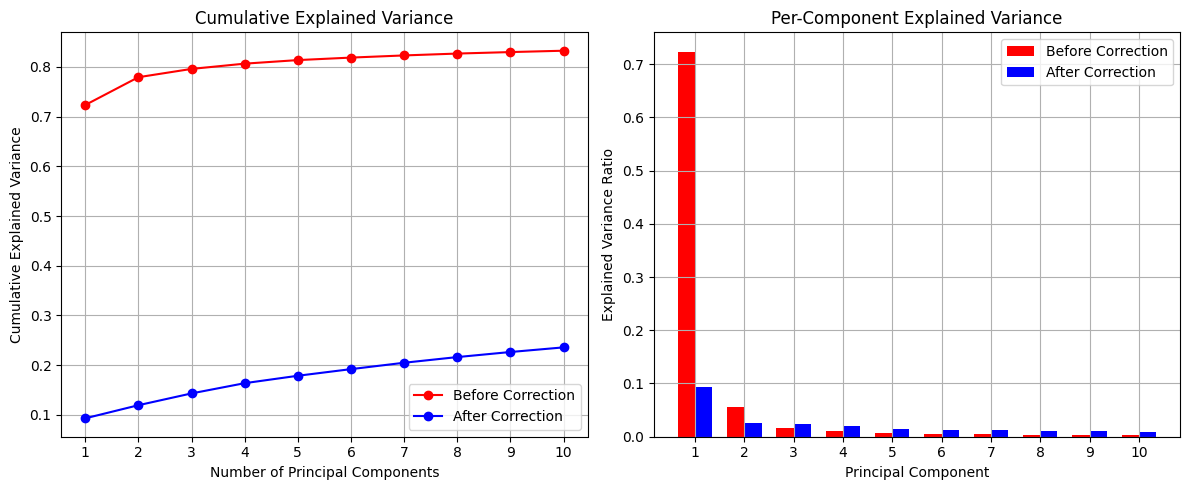

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 读取文件
before_df = pd.read_csv("merged_qnorm_log2.csv")
after_df = pd.read_csv("merged_qnorm_combat.csv")

# 提取表达矩阵（去除元数据列）
X_before = before_df.drop(columns=["SampleID", "Dataset"]).values
X_after = after_df.drop(columns=["SampleID", "Dataset"]).values

# PCA 拟合
pca_before = PCA(n_components=10).fit(X_before)
pca_after = PCA(n_components=10).fit(X_after)

# 获取解释度数据
explained_before = pca_before.explained_variance_ratio_
explained_after = pca_after.explained_variance_ratio_
cumulative_before = np.cumsum(explained_before)
cumulative_after = np.cumsum(explained_after)

# 设置图形
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# 左图：累计解释方差
axs[0].plot(range(1, 11), cumulative_before, marker='o', color='red', label='Before Correction')
axs[0].plot(range(1, 11), cumulative_after, marker='o', color='blue', label='After Correction')
axs[0].set_title("Cumulative Explained Variance")
axs[0].set_xlabel("Number of Principal Components")
axs[0].set_ylabel("Cumulative Explained Variance")
axs[0].set_xticks(np.arange(1, 11, 1))  # ✅ 设置横坐标为整数步长
axs[0].legend()
axs[0].grid(True)

# 右图：每个主成分解释度
bar_width = 0.35
index = np.arange(1, 11)
axs[1].bar(index - bar_width/2, explained_before, bar_width, color='red', label='Before Correction')
axs[1].bar(index + bar_width/2, explained_after, bar_width, color='blue', label='After Correction')
axs[1].set_title("Per-Component Explained Variance")
axs[1].set_xlabel("Principal Component")
axs[1].set_ylabel("Explained Variance Ratio")
axs[1].set_xticks(np.arange(1, 11, 1))  # ✅ 设置横坐标为整数步长
axs[1].legend()
axs[1].grid(True)

# 保存与显示
plt.tight_layout()
plt.savefig("explained_variance_comparison.png", dpi=300)
plt.show()

In [29]:
import pandas as pd

# 读取合并后的文件
df = pd.read_csv("merged_qnorm_combat.csv")

# 获取唯一数据集名称
datasets = df["Dataset"].unique()

# 依次保存每个子数据集为独立文件
for ds in datasets:
    subset = df[df["Dataset"] == ds]
    filename = f"{ds}.csv"
    subset.to_csv(filename, index=False)

print("✅ 拆分完成，每个数据集已保存为 dataset_<Dataset>.csv")

✅ 拆分完成，每个数据集已保存为 dataset_<Dataset>.csv
